<a href="https://colab.research.google.com/github/B0BWAX/PRIMA-INDIANS-DIABETES-PREDICTION/blob/main/PREPROCESSING_AND_TRAINING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# using kaggle API
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/API-KEYS/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# download dataset
!kaggle datasets download -d uciml/pima-indians-diabetes-database

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 20.4MB/s]


In [4]:
!unzip pima-indians-diabetes-database.zip

Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import metrics, regularizers
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import pickle
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [6]:
# Load dataset
data = pd.read_csv("diabetes.csv")

In [7]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Preprocessing

In [9]:
# Data cleaning
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
data[cols_with_zeros] = data[cols_with_zeros].replace(0, np.nan)
data[cols_with_zeros] = data[cols_with_zeros].fillna(data[cols_with_zeros].median())

In [10]:
# Split data into features and target variable
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

In [11]:
#Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Artificial Neural Network (ANN)

In [51]:
# Function to build ANN model
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X_scaled.shape[1], activation="relu"))
    model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(16, input_dim=X_scaled.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[metrics.AUC()])
    return model

In [32]:
#Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [52]:
#Perform cross-validation
conf_matrices = []
accuracies = []
for train_idx, val_idx in cv.split(X_scaled, y):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=50, batch_size=4, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])

    #Predict probabilities on validation set
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)

    #Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    conf_matrices.append(conf_matrix)

5/5 [==============================] - 0s 2ms/step


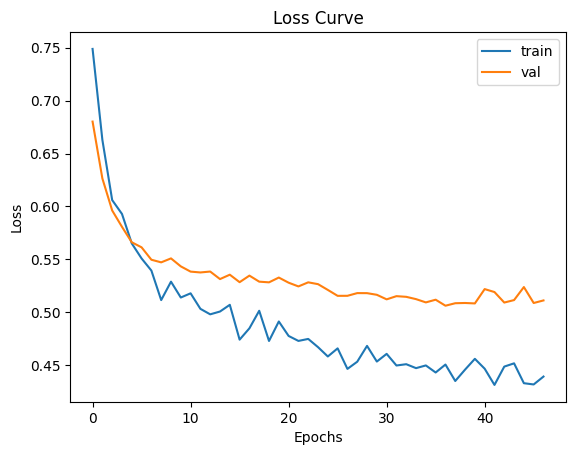

In [53]:
#Plot loss curve for last model
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

In [54]:
print(history.history.keys())

dict_keys(['loss', 'auc_11', 'val_loss', 'val_auc_11'])


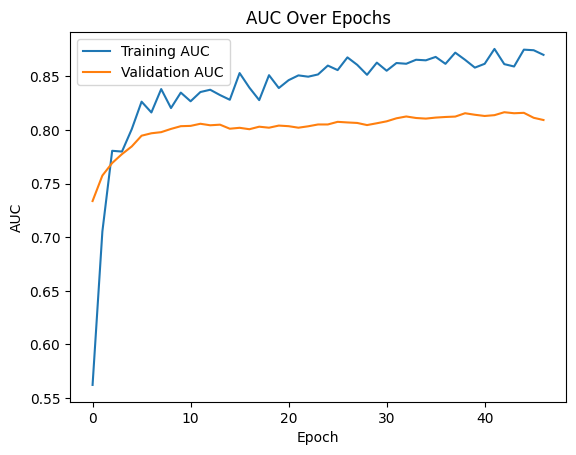

In [55]:
train_auc = history.history['auc_11']
val_auc = history.history['val_auc_11']

# Plot AUC metric for last model
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Over Epochs')
plt.legend()
plt.show()

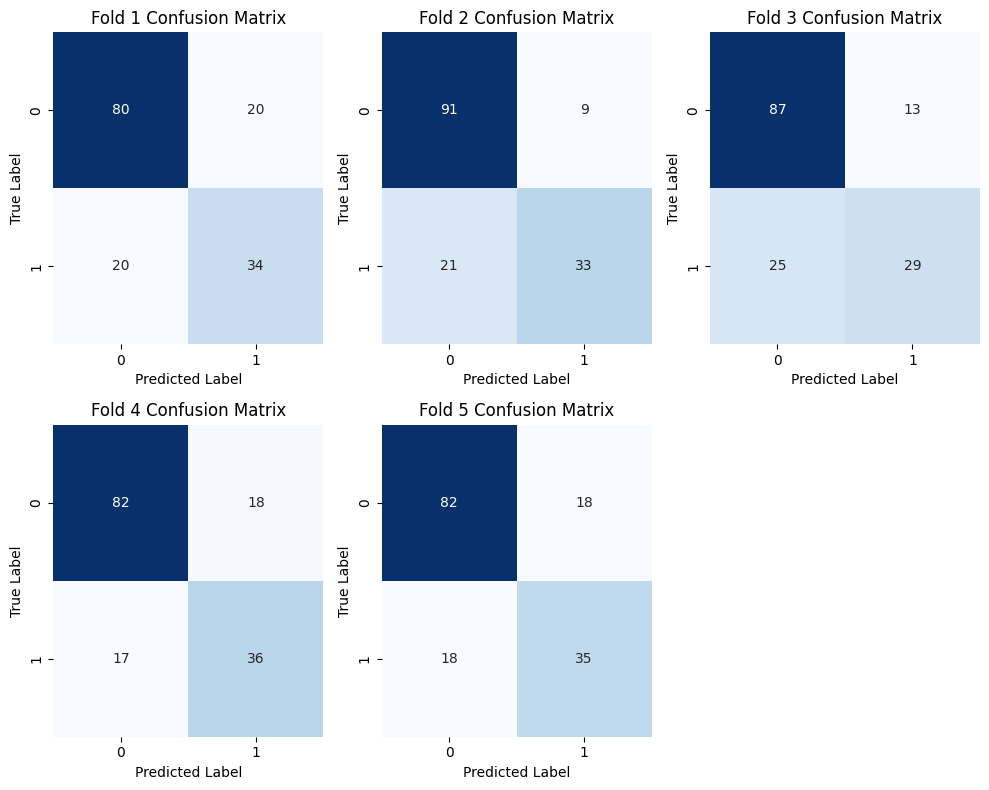

In [56]:
#Plot confusion matrix
plt.figure(figsize=(10, 8))
for i, conf_matrix in enumerate(conf_matrices):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Fold {i+1} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [57]:
#Print mean accuracy and standard deviation
print("Mean Accuracy For ANN:", np.mean(accuracies))

Mean Accuracy For ANN: 0.7669298022239198


5/5 [==============================] - 0s 3ms/step


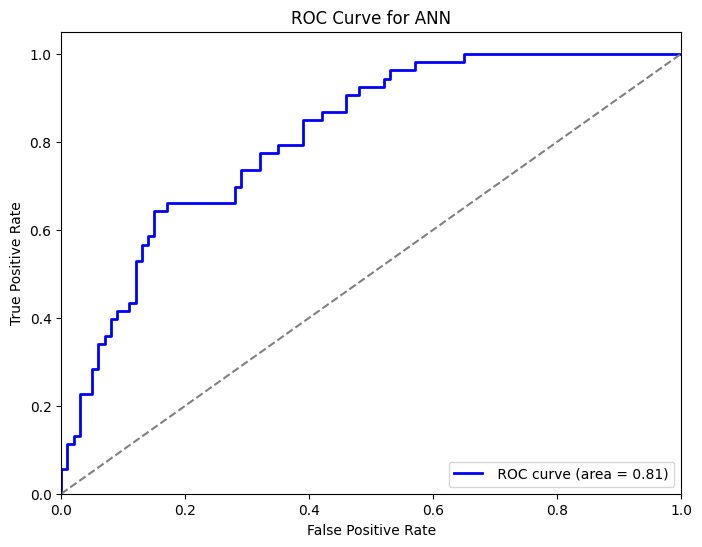

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve for ANN
ann_y_pred_proba = model.predict(X_val)
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_val, ann_y_pred_proba)
roc_auc_ann = roc_auc_score(y_val, ann_y_pred_proba)

# Plot ROC curve for ANN
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, color='blue', lw=2, label=f' ROC curve (area = {roc_auc_ann:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN')
plt.legend(loc="lower right")
plt.show()


In [60]:
model.save('ANN_model.keras')

### Decision Tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
# Define hyperparameters grid for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=cv, scoring='roc_auc')
grid_search.fit(X_scaled, y)

# Get the best model
best_dt_model = grid_search.best_estimator_

with open('DT_Model.pkl', 'wb') as f: # save model
    pickle.dump(best_dt_model, f)

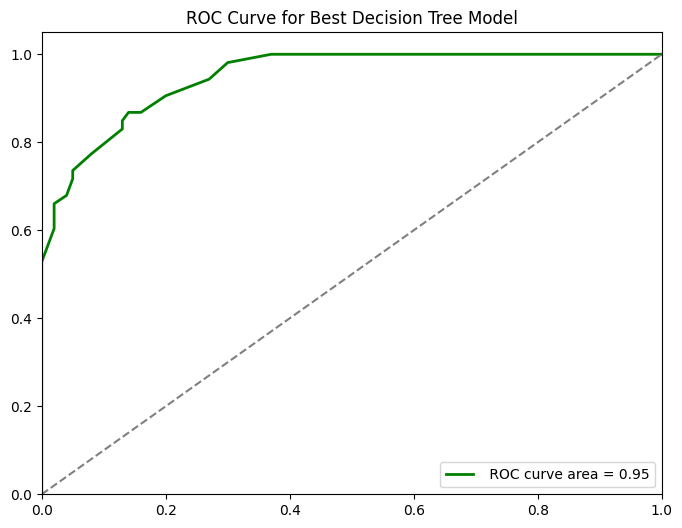

In [66]:
# Plot ROC curve for the best Decision Tree model
best_dt_y_pred_proba = best_dt_model.predict_proba(X_val)[:, 1]
fpr_best_dt, tpr_best_dt, thresholds_best_dt = roc_curve(y_val, best_dt_y_pred_proba)
roc_auc_best_dt = roc_auc_score(y_val, best_dt_y_pred_proba)

# Plot ROC curve for the best Decision Tree model
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_dt, tpr_best_dt, color='green', lw=2, label=f' ROC curve area = {roc_auc_best_dt:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title('ROC Curve for Best Decision Tree Model')
plt.legend(loc="lower right")
plt.show()